# **DOWNLOADING THE DATASET**

In [1]:
#This method downloads the dataset using the kaggle API key
import os
import opendatasets as od

class Downloader:
    def __init__(self, data_url):
        self.d = data_url
        od.download(self.d)
    
    def list_files(self, directory):
        return os.listdir(directory)

data_url = "https://kaggle.com/competitions/playground-series-s4e8"
downloader = Downloader(data_url)
print(downloader.list_files('playground-series-s4e8'))

Skipping, found downloaded files in ".\playground-series-s4e8" (use force=True to force download)
['sample_submission.csv', 'test.csv', 'train.csv']


# **IMPORTING MODULES**

In [2]:
#modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [3]:
#submission path
subs = pd.read_csv('playground-series-s4e8/sample_submission.csv')
#training path
df1 = pd.read_csv('playground-series-s4e8/train.csv')
#testing path
df2 = pd.read_csv('playground-series-s4e8/test.csv')

class get_summary:
    def __init__(self, x):
        self.x = x
    def data_set(self):
        #checks for duplicate
        duplicate = self.x.duplicated().any()
        #drop duplicates 
        if duplicate == True:
            self.x.drop_duplicates(inplace=True)
            self.x.reset_index(drop=True)
        #checks for empty values
        null = self.x.isna().sum().any()
        #missing values
        total_missing = self.x.isnull().sum().sum()
        #data types
        data_type = self.x.dtypes
        #shape
        shapes = self.x.shape
        return f"Duplicate: {duplicate}\nNull: {null}\nMissing_value: {total_missing}\nTypes:\n{data_type}\nShape: {shapes}"
    
print(f"Training dataset:\n{get_summary(df1).data_set()}\nTest dataset:\n{get_summary(df2).data_set()}")

Training dataset:
Duplicate: False
Null: True
Missing_value: 15868508
Types:
id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object
Shape: (3116945, 22)
Test dataset:
Duplicate: False
Null: True
Missing_value: 10579477
Types:
id                        int64
cap-diameter            float64
cap-shape                object
cap-surface    

# **ANALYSIS AND DATA CLEANING**

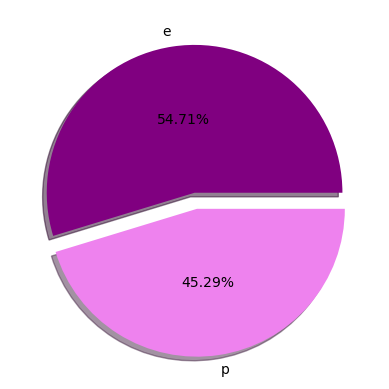

In [4]:
#This function return the values in % for the target where 'e' represent {edible} and 'p' represent  {poisonous}
def pie_chat(data):
    plt.pie(data.value_counts(),
            labels=data.unique(),
            autopct='%.2f%%',
            shadow=True,
            pctdistance=0.5,
            colors=('purple', 'violet'),
            explode=[0.01, 0.1])
    plt.show()
pie_chat(df1['class'])

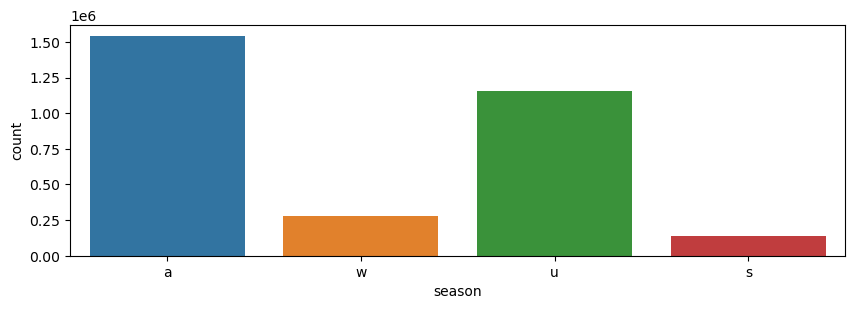

In [5]:
plt.figure(figsize=(10, 3))
sns.countplot(df1, x=df1['season'])
plt.show()

In [6]:
#this function returns colummns with null values and drop null values greater than 100
def columns_with_missing_values(df1):
    missing = df1.isnull().sum()
    missing_cols = missing[missing > 0].to_dict()

    #this line drop columns with missing values greater than 100
    drop_cols = missing[missing > 100].index
    df1.drop(drop_cols, axis=1, inplace=True)
    
    return f"MISSING VALUES:\n{missing_cols}"

print(columns_with_missing_values(df1))

MISSING VALUES:
{'cap-diameter': 4, 'cap-shape': 40, 'cap-surface': 671023, 'cap-color': 12, 'does-bruise-or-bleed': 8, 'gill-attachment': 523936, 'gill-spacing': 1258435, 'gill-color': 57, 'stem-root': 2757023, 'stem-surface': 1980861, 'stem-color': 38, 'veil-type': 2957493, 'veil-color': 2740947, 'has-ring': 24, 'ring-type': 128880, 'spore-print-color': 2849682, 'habitat': 45}


# **SPLITTING AND ENCODING**

In [7]:
#training features
features = df1.drop(['id', 'class'], axis=1)

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cap-diameter          float64
 1   cap-shape             object 
 2   cap-color             object 
 3   does-bruise-or-bleed  object 
 4   gill-color            object 
 5   stem-height           float64
 6   stem-width            float64
 7   stem-color            object 
 8   has-ring              object 
 9   habitat               object 
 10  season                object 
dtypes: float64(3), object(8)
memory usage: 261.6+ MB


In [9]:
#categorical columns
cat_cols = features.select_dtypes(include=['object'])
cat_cols.head(2)

,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,f,u,f,w,w,f,d,a
1,x,o,f,n,o,t,d,w


In [10]:
#filling missing values in categorical columns 
cat_cols.fillna('Unknown', inplace=True)

In [11]:
cat_cols.isna().sum().any()# checking for null values in categorical columns 

False

In [12]:
#numeric columns
num_cols = features.select_dtypes(include=['float'])
num_cols.head(2)

,cap-diameter,stem-height,stem-width
0,8.80,4.51,15.39
1,4.51,4.79,6.48


In [13]:
num_cols.fillna(0, inplace=True)#filling missing values in categorical columns

In [14]:
num_cols.isna().sum().any()# checking for null values in numerical columns 

False

In [15]:
#this function encode the categorical columns
lab_enc = LabelEncoder()
def encoder(data):
    #encoding
    for col in data.columns:
        data[col] = lab_enc.fit_transform(data[col])
    return data.head(3)

encoder(cat_cols)

,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,54,73,9,60,56,6,26,0
1,72,65,9,47,48,19,26,3
2,54,50,9,60,47,6,37,3


In [16]:
#merging categorical columns and numerical columns 
merged_features = pd.concat([num_cols, cat_cols], axis=1)
merged_features.head(2)

,cap-diameter,stem-height,stem-width,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,8.80,4.51,15.39,54,73,9,60,56,6,26,0
1,4.51,4.79,6.48,72,65,9,47,48,19,26,3


In [17]:
#scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(merged_features))
X.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.109086,0.050834,0.149563,0.729730,0.935897,0.346154,0.952381,0.949153,0.260870,0.5,0.0
1,0.055907,0.053990,0.062974,0.972973,0.833333,0.346154,0.746032,0.813559,0.826087,0.5,1.0


In [18]:
#encoding the target
y = df1['class'].map(lambda x: {'e' : 0, 'p' : 1}[x])
y

0          0
1          1
2          0
3          0
4          0
          ..
3116940    0
3116941    0
3116942    1
3116943    0
3116944    1
Name: class, Length: 3116945, dtype: int64

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=100)
# Check shapes
for i in (X_train, X_val, y_train, y_val):
    print(list(i.shape))

[2181861, 11]
[935084, 11]
[2181861]
[935084]


In [20]:
#defining the metrics function
def mcc_(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [21]:
#xgb_model
model = XGBClassifier(                    
    alpha=0.1,                   
    subsample=0.8,     
    colsample_bytree=0.55,  
    objective='binary:logistic',
    max_depth=14,             
    min_child_weight=7,         
    gamma=1e-6,                
    random_state=100,                 
    n_estimators=500,
    learning_rate=0.5
    )

#fittting
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)],
    eval_metric=mcc_)

C:\Users\hp\.conda\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.41697	validation_0-mcc:0.81127
[1]	validation_0-logloss:0.28331	validation_0-mcc:0.90247
[2]	validation_0-logloss:0.21783	validation_0-mcc:0.91227
[3]	validation_0-logloss:0.18554	validation_0-mcc:0.92129
[4]	validation_0-logloss:0.14807	validation_0-mcc:0.93598
[5]	validation_0-logloss:0.13083	validation_0-mcc:0.93914
[6]	validation_0-logloss:0.11141	validation_0-mcc:0.94495
[7]	validation_0-logloss:0.10050	validation_0-mcc:0.94848
[8]	validation_0-logloss:0.08938	validation_0-mcc:0.95215
[9]	validation_0-logloss:0.08429	validation_0-mcc:0.95333
[10]	validation_0-logloss:0.08050	validation_0-mcc:0.95473
[11]	validation_0-logloss:0.07556	validation_0-mcc:0.95656
[12]	validation_0-logloss:0.07422	validation_0-mcc:0.95709
[13]	validation_0-logloss:0.07331	validation_0-mcc:0.95748
[14]	validation_0-logloss:0.07200	validation_0-mcc:0.95790
[15]	validation_0-logloss:0.07048	validation_0-mcc:0.95851
[16]	validation_0-logloss:0.06985	validation_0-mcc:0.95884
[17]	va

[139]	validation_0-logloss:0.07049	validation_0-mcc:0.95957
[140]	validation_0-logloss:0.07059	validation_0-mcc:0.95953
[141]	validation_0-logloss:0.07063	validation_0-mcc:0.95957
[142]	validation_0-logloss:0.07065	validation_0-mcc:0.95959
[143]	validation_0-logloss:0.07070	validation_0-mcc:0.95952
[144]	validation_0-logloss:0.07075	validation_0-mcc:0.95949
[145]	validation_0-logloss:0.07077	validation_0-mcc:0.95951
[146]	validation_0-logloss:0.07087	validation_0-mcc:0.95945
[147]	validation_0-logloss:0.07087	validation_0-mcc:0.95946
[148]	validation_0-logloss:0.07090	validation_0-mcc:0.95948
[149]	validation_0-logloss:0.07093	validation_0-mcc:0.95945
[150]	validation_0-logloss:0.07097	validation_0-mcc:0.95939
[151]	validation_0-logloss:0.07099	validation_0-mcc:0.95941
[152]	validation_0-logloss:0.07102	validation_0-mcc:0.95941
[153]	validation_0-logloss:0.07110	validation_0-mcc:0.95936
[154]	validation_0-logloss:0.07114	validation_0-mcc:0.95934
[155]	validation_0-logloss:0.07120	valid

[276]	validation_0-logloss:0.07497	validation_0-mcc:0.95836
[277]	validation_0-logloss:0.07499	validation_0-mcc:0.95841
[278]	validation_0-logloss:0.07501	validation_0-mcc:0.95837
[279]	validation_0-logloss:0.07506	validation_0-mcc:0.95831
[280]	validation_0-logloss:0.07511	validation_0-mcc:0.95830
[281]	validation_0-logloss:0.07514	validation_0-mcc:0.95829
[282]	validation_0-logloss:0.07518	validation_0-mcc:0.95828
[283]	validation_0-logloss:0.07525	validation_0-mcc:0.95820
[284]	validation_0-logloss:0.07525	validation_0-mcc:0.95825
[285]	validation_0-logloss:0.07525	validation_0-mcc:0.95822
[286]	validation_0-logloss:0.07529	validation_0-mcc:0.95826
[287]	validation_0-logloss:0.07536	validation_0-mcc:0.95828
[288]	validation_0-logloss:0.07544	validation_0-mcc:0.95824
[289]	validation_0-logloss:0.07548	validation_0-mcc:0.95818
[290]	validation_0-logloss:0.07552	validation_0-mcc:0.95822
[291]	validation_0-logloss:0.07554	validation_0-mcc:0.95818
[292]	validation_0-logloss:0.07555	valid

[413]	validation_0-logloss:0.07927	validation_0-mcc:0.95688
[414]	validation_0-logloss:0.07930	validation_0-mcc:0.95687
[415]	validation_0-logloss:0.07932	validation_0-mcc:0.95688
[416]	validation_0-logloss:0.07940	validation_0-mcc:0.95687
[417]	validation_0-logloss:0.07943	validation_0-mcc:0.95686
[418]	validation_0-logloss:0.07945	validation_0-mcc:0.95683
[419]	validation_0-logloss:0.07947	validation_0-mcc:0.95687
[420]	validation_0-logloss:0.07952	validation_0-mcc:0.95684
[421]	validation_0-logloss:0.07954	validation_0-mcc:0.95687
[422]	validation_0-logloss:0.07961	validation_0-mcc:0.95679
[423]	validation_0-logloss:0.07960	validation_0-mcc:0.95688
[424]	validation_0-logloss:0.07962	validation_0-mcc:0.95689
[425]	validation_0-logloss:0.07965	validation_0-mcc:0.95687
[426]	validation_0-logloss:0.07968	validation_0-mcc:0.95685
[427]	validation_0-logloss:0.07972	validation_0-mcc:0.95680
[428]	validation_0-logloss:0.07975	validation_0-mcc:0.95683
[429]	validation_0-logloss:0.07975	valid

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1e-06, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
#prediction
preds = model.predict(X_val)
#matthews score
matthews = matthews_corrcoef(y_val, preds) 

#classification report 
classifier = classification_report(y_val, preds)

print(f"Accuracy: {matthews:.2f}%\nClassification_report:\n{classifier}")

Accuracy: 0.96%
Classification_report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    422782
           1       0.98      0.98      0.98    512302

    accuracy                           0.98    935084
   macro avg       0.98      0.98      0.98    935084
weighted avg       0.98      0.98      0.98    935084



**yikees we doing good so far**

# **WORKING ON df2**

In [23]:
#calling the columns_with_missing_values on df2
print(columns_with_missing_values(df2))

MISSING VALUES:
{'cap-diameter': 7, 'cap-shape': 31, 'cap-surface': 446904, 'cap-color': 13, 'does-bruise-or-bleed': 10, 'gill-attachment': 349821, 'gill-spacing': 839595, 'gill-color': 49, 'stem-height': 1, 'stem-root': 1838012, 'stem-surface': 1321488, 'stem-color': 21, 'veil-type': 1971545, 'veil-color': 1826124, 'has-ring': 19, 'ring-type': 86195, 'spore-print-color': 1899617, 'habitat': 25}


In [24]:
#test features
test_features = df2.drop('id', axis=1)
test_features.head(2)

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
0,8.64,x,n,t,w,11.13,17.12,w,t,d,a
1,6.90,o,o,f,y,1.27,10.75,n,f,d,a


In [25]:
#test categorical columns 
test_cat_cols = test_features.select_dtypes(include=['object'])
test_cat_cols.head(2)

,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,x,n,t,w,w,t,d,a
1,o,o,f,y,n,f,d,a


In [26]:
#filling missing values in categorical columns 
test_cat_cols.fillna('Unknown', inplace=True)
test_cat_cols.isna().sum().any()#checking for null values

False

In [27]:
#numeric columns
test_num_cols = test_features.select_dtypes(include=['float'])
test_num_cols.head(2)

,cap-diameter,stem-height,stem-width
0,8.64,11.13,17.12
1,6.90,1.27,10.75


In [28]:
test_num_cols.fillna(0, inplace=True)#filling missing values in categorical columns
test_num_cols.isna().sum().any()#checking for null values

False

In [29]:
#calling the encoder function on test_cat_cols
encoder(test_cat_cols)

,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,60,45,19,53,52,18,17,0
1,51,46,6,55,39,7,17,0
2,37,45,6,42,39,7,17,1


In [30]:
#merging categorical columns and numerical columns 
merged_test_features = pd.concat([test_num_cols, test_cat_cols], axis=1)
merged_test_features.head(2)

,cap-diameter,stem-height,stem-width,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
0,8.64,11.13,17.12,60,45,19,53,52,18,17,0
1,6.90,1.27,10.75,51,46,6,55,39,7,17,0


In [31]:
#scalling
X_test = pd.DataFrame(scaler.fit_transform(merged_test_features))
X_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.014234,0.194275,0.166359,0.967742,0.789474,0.863636,0.946429,0.945455,0.782609,0.435897,0.0
1,0.011367,0.022168,0.104460,0.822581,0.807018,0.272727,0.982143,0.709091,0.304348,0.435897,0.0


In [32]:
#prediction
prediction = model.predict(X_test)
prediction

array([0, 1, 1, ..., 1, 1, 1])

In [34]:
subs['class'] = prediction
subs.head(10)

,id,class
0,3116945,0
1,3116946,1
2,3116947,1
3,3116948,1
4,3116949,0
5,3116950,1
6,3116951,1
7,3116952,1
8,3116953,1
9,3116954,0


In [35]:
subs['class'] = subs['class'].map(lambda x: {0: 'e', 1: 'p'}[x])
subs.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
